In [1]:
#------------------------------------1.1 下载CIFAR-10数据集----------------------------------------------------
import urllib.request
import os
import tarfile

In [4]:
# 下载
url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
filepath = 'data/cifar-10-python.tar.gz'
if not os.path.isfile(filepath):
    result = urllib.request.urlretrieve(url, filepath)
    print("downloaded: ", result)
else:
    print('Data file already exists!')

# 解压
if not os.path.exists("data/cifar-10-batches-py"):
    tfile = tarfile.open('data/cifar-10-python.tar.gz')
    result = tfile.extractall('data/')
    print("Extract to ./data/cifar/cifar-10-batches-py/")
else:
    print('Directory already exists!')

Data file already exists!
Extract to ./data/cifar/cifar-10-batches-py/


In [5]:
import tensorflow as tf
import numpy as np
import pickle as p

In [6]:
def load_CIFAR_batch(filename): # 读取一个批次的样本，10000条
    """load single batch of cifar"""
    with open(filename,"rb") as f:
        # 一个样本由标签和图像数据组成
        # <1×label><3072×pixel>(3072=32*32*3)
        data_dict = p.load(f, encoding="bytes")
        images = data_dict[b"data"]
        labels = data_dict[b'labels']

        # 把原始数据结构调整为BCWH(batches,channels,width,height)
        images = images.reshape(10000, 3, 32, 32)   # 四维数组，维度的索引分别为0,1,2,3
        # tensorflow处理数据图像的结构BWHC
        # 所以要把通道数据移动到最后一个维度:transpose函数是按照后面参数(可以理解为围绕的轴)对原数四维组进行转置
        # 对照维度的索引，大致是把索引重新排列以实现转置（0,1,2,3）-（0,2,3,1），就是把原来索引1排到末尾了
        # 一般低维数组（一维二维）用.T进行转置，高维数组用.transpose(索引参数)进行转置
        images = images.transpose(0,2,3,1)
        labels = np.array(labels)
        return images, labels

def load_CIFAR_data(data_dir):   # 完整读取数据集
    """load cifar data"""
    images_train = []
    labels_train = []
    for i in range(5):
        f = os.path.join(data_dir, 'data_batch_%d' % (i+1))
        print('loading', f)
        # 调用load_CIFAR_batch()获得批量的图像及其对应的标签
        image_batch, label_batch = load_CIFAR_batch(f)
        images_train.append(image_batch)
        labels_train.append(label_batch)
        # np.concatenate函数实现将多个数组进行合并成为一个数组，合并结果会降低一维(将索引为0和1的两维合并成一维)
        # 如原先的数组为(4,2,2)，用np.concatenate()后变成两维(8,2)数组
        Xtrain = np.concatenate(images_train)
        Ytrain = np.concatenate(labels_train)
        del image_batch, label_batch

    Xtest, Ytest = load_CIFAR_batch(os.path.join(data_dir, 'test_batch'))
    print('finished loading CIFAR-10 data!')

    # 返回训练集图像和标签，测试集图像和标签
    return Xtrain, Ytrain, Xtest, Ytest

In [7]:
#--------------------------------1.2 导入数据集的数据-------------------------------------------
# 调用数据读取的函数读取数据
data_dir = 'data/cifar-10-batches-py/'
Xtrain, Ytrain, Xtest, Ytest = load_CIFAR_data(data_dir)

loading data/cifar-10-batches-py/data_batch_1
loading data/cifar-10-batches-py/data_batch_2
loading data/cifar-10-batches-py/data_batch_3
loading data/cifar-10-batches-py/data_batch_4
loading data/cifar-10-batches-py/data_batch_5
finished loading CIFAR-10 data!


In [8]:
#--------------------------------1.3 察看相关数据信息-------------------------------------------
# 察看数据集的信息
print("training data shape: ", Xtrain.shape)  # (50000, 32, 32, 3)
print("training label shape: ", Ytrain.shape) # (50000,)
print("testing data shape: ", Xtest.shape)    # (10000, 32, 32, 3)
print("testing data shape: ", Ytest.shape)    # (10000, )

training data shape:  (50000, 32, 32, 3)
training label shape:  (50000,)
testing data shape:  (10000, 32, 32, 3)
testing data shape:  (10000,)


In [9]:
import matplotlib.pyplot as plt

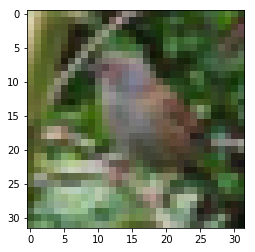

1
5


In [10]:
# 察看单项image和label
%matplotlib inline
plt.imshow(Xtrain[5])
plt.imshow(Xtest[65])
plt.show()
print(Ytrain[5])
print(Ytest[1000])

In [12]:
label_dict = {0: 'airplane', 1: 'automobile', 2: 'bird', 3:'cat', 4: 'deer', 5: 'dog', 6:'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

def plot_images_labels_prediction(images, labels, prediction, idx, num=10):
    fig = plt.gcf()
    fig.set_size_inches(12, 6)
    if num > 10:
        num = 10
    for i in range(0, num):
        ax = plt.subplot(2, 5, i+1)
        ax.imshow(images[idx], cmap='binary')

        title = str(i) + ',' + label_dict[labels[idx]]
        if len(prediction) > 0:
            title += '=>' + label_dict[prediction[idx]]

        ax.set_title(title, fontsize=10)

        idx += 1
    plt.show()

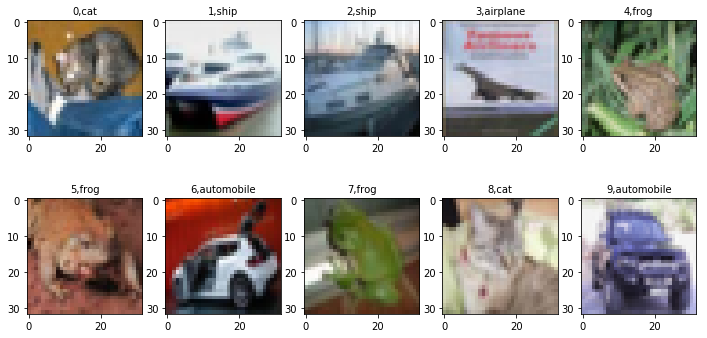

In [13]:
# 调用图像和标签察看函数察看多个图片和标签
plot_images_labels_prediction(Xtest, Ytest, [], 0, 10)

In [14]:
#---------------------------------------1.4 数据预处理---------------------------------------------------
# 1.4.1 图像数据预处理
# 显示第一张图的第一个像素点（[0][0][0]分别表示三通道r/g/b的值）
print(Xtrain[0][0][0])    # 结果[59 62 63]

# 将图像进行数字标准化
Xtrain_normalize = Xtrain.astype('float32') / 255.0
Xtest_normalize = Xtest.astype('float32') / 255.0

[59 62 63]


In [15]:
# 察看处理后的图像数据
print(Xtrain_normalize[0][0][0])  # 结果[0.23137255 0.24313726 0.24705882]

[0.23137255 0.24313726 0.24705882]


In [16]:
# 标签数据预处理
# 当前的标签数据是对应的0-9的数字，需要转成独热编码（one-hot encoding）
print(Ytrain[0:10])   # 结果[6 9 9 4 1 1 2 7 8 3]

[6 9 9 4 1 1 2 7 8 3]


In [17]:
# 转换成独热编码的代码
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
yy = [[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]]
encoder.fit(yy)
Ytrain_reshape = Ytrain.reshape(-1, 1)
Ytrain_onehot = encoder.transform(Ytrain_reshape)
Ytest_reshape = Ytrain.reshape(-1, 1)
Ytest_onehot = encoder.transform(Ytest_reshape)

In [18]:
print(Ytrain_onehot[0:10])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


In [20]:
#-------------------------------- 步骤2：构建CIFAR-10的图像分类模型------------------------------------------------
"""
模型的架构：
    - 输入层：32*32图像，rgb三通道
    - 卷积层1（第一次卷积）：输入通道3；输出通道32；卷积后图像尺寸不变
    - 降采样层1（第一次降采样）：将32*32的图像缩小为16*16；降采样（池化）不改变通道数量，因此依然是32个
    - 卷积层2（第二次卷积）：输入通道32，输出通道64，卷积后图像尺寸不变，依然是16*16
    - 降采样层2（第二次降采样）：将16*16的图像缩小为8*8，降采样（池化）不改变通道数量（64）
    - 全连接层：将64个8*8的图像转换成长度是4096（=64*8*8）的一维向量，该层共计128个神经元
    - 输出层：输出层共10个神经元，对应0-9这10个类别
图像特征的提取：通过卷积层1、降采样层1、卷积层2、降采样层2的处理，提出图像特征
全连接神经网络：全连接层和输出层构成的网络结构
"""

tf.reset_default_graph()   # 清空tensorboard的graph

In [21]:
#定义后面都要用到的共享函数

# 定义权值函数
def weight(shape):
    """在构建模型时，需要使用tf.Variable来创建变量，训练时这个变量会不断更新
       这里使用tf.truncated_normal(截断型正态分布)生成标准差为0.1的随机数来初始化权值"""
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name='W')

# 定义偏置项，并初始化为0.1
def bias(shape):
    return tf.Variable(tf.constant(0.1, shape=shape), name='b')

# 定义卷积操作：步长为1，padding为SAME(卷积之后图像的大小不变)
def conv2d(x, W):
    """直接使用tensorflow内置的卷积函数"""
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

# 定义池化操作：步长为2，即原尺寸的长宽各除以2
def max_pool_2x2(x):
    """直接使用tensorflow内置的最大值降采样函数"""
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [22]:
#-------------------------------- 2.2 定义网络结构------------------------------------------------
# 输入层：32*32的图像，通道3
with tf.name_scope('input_layer'):
    x = tf.placeholder('float', shape=[None, 32, 32, 3], name='x')

In [23]:
# 卷积层1：输入通道3，输出通道32， 卷积后图像尺寸不变，还是32*32
with tf.name_scope('conv_1'):
    W1 = weight([3,3,3,32]) # [k_weight,k_height,input_chn,output_chn][卷积核宽，卷积核高，输入通道数，输出通道数]
    b1 = bias([32]) # 与output_chn一致
    conv_1 = conv2d(x, W1) + b1
    conv_1 = tf.nn.relu(conv_1)

In [24]:
# 池化层1：将32*32的图像缩小为16*16，池化不改变通道数，因此依然是32个
with tf.name_scope('pool_1'):
    pool_1 = max_pool_2x2(conv_1)

In [25]:
# 卷积层2：输入通道32，输出通道64，卷积后图像尺寸不变（16*16）
with tf.name_scope('conv_2'):
    W2 = weight([3,3,32,64])
    b2 = bias([64])
    conv_2 = conv2d(pool_1, W2) + b2
    conv_2 = tf.nn.relu(conv_2)

In [26]:
# 池化层2：将16*16的图像缩小为8*8，池化不改变通道数，因此依然是64个
with tf.name_scope('pool_2'):
    pool_2 = max_pool_2x2(conv_2)

In [27]:
# 全连接层：共128个神经元。将池化层2输出的64个8*8的图像转换成一维向量，长度是64*8*8=4096
with tf.name_scope('fc'):
    W3 = weight([4096, 128])   # 每个神经元都与4096个像素点进行全连接（神经元个数128可以调整）
    b3 = bias([128])
    flat = tf.reshape(pool_2, [-1, 4096])
    # 参数-1在reshape中表示，如果不知道行的个数，用-1指定，tf会自动计算行数，最终形成结果（列数为-1时类似）
    h = tf.nn.relu(tf.matmul(flat, W3) + b3)
    h_dropout = tf.nn.dropout(h, keep_prob=0.8)   # dropout是用来防止或减轻过拟合的方法，一般用在全连接层


In [28]:
# 输出层：共10个神经元，对应0-9这10个数字
with tf.name_scope('output_layer'):
    W4 = weight([128, 10])
    b4 = bias([10])
    pred = tf.nn.softmax(tf.matmul(h_dropout, W4) + b4)

In [29]:
#-------------------------------- 2.3 构建训练模型------------------------------------------------
with tf.name_scope('optimizer'):
    # 定义占位符
    y = tf.placeholder('float', shape=[None, 10], name='label')
    # 定义损失函数
    loss_func = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
    # 选择优化器
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss_func)  
    # 开始学习率设为0.01时，每次返回的损失值和准确率保持不变。把学习率调小了才可以正常地下降


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [30]:
# 定义准确率
with tf.name_scope('evaluation'):
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))


In [31]:
#------------------------------------- 步骤3：训练模型 -----------------------------------------------
#-----------------------------------3.1 定义参数，启动会话---------------------------------------------
from time import time

In [32]:
# 定义参数
train_epochs = 50
batch_size = 50
total_batch = int(len(Xtrain) / batch_size)
epoch_list = []
accuracy_list = []
loss_list = []

epoch = tf.Variable(0, name='epoch', trainable=False)

startTime = time()

sess = tf.Session()
sess.run(tf.global_variables_initializer())


In [33]:
#-----------------------------------------3.2 断点续训-------------------------------------------------------
#设置检查点存储目录
ckpt_dir = 'CIFAR10_log/'
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

In [34]:
#生成saver
saver = tf.train.Saver(max_to_keep=1)   # 包含了程序中定义的所有变量


In [35]:
# 如果有检查点文件，则读取最新的检查点文件，恢复各变量值
ckpt = tf.train.latest_checkpoint(ckpt_dir)
if ckpt != None:
    saver.restore(sess, ckpt) # 加载所有的参数
    # 从这里开始就可以直接使用模型进行预测，或者接着训练了
else:
    print('Training from scratch!')


Training from scratch!


In [36]:
# 获取续训参数（断点位于第几轮）
start = sess.run(epoch)
print('Training starts from {} epoch'.format(start+1))


Training starts from 1 epoch


In [37]:
#-----------------------------------------3.3 迭代训练-------------------------------------------------------
# 批量获取训练数据的函数：返回的是经过归一化的图像和标签数据
def get_train_batch(number, batch_size):
    return Xtrain_normalize[number * batch_size:(number+1) * batch_size], \
           Ytrain_onehot[number * batch_size:(number+1) * batch_size]

for ep in range(start, train_epochs):
    for i in range(total_batch):
        batch_x, batch_y = get_train_batch(i, batch_size)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        if i % 100 ==0:
            print("Step {}".format(i), "finished")

    loss, acc = sess.run([loss_func, accuracy], feed_dict={x: batch_x, y: batch_y})
    epoch_list.append(ep+1)
    loss_list.append(loss)
    accuracy_list.append(acc)

    print("训练轮次：", "%02d" % (sess.run(epoch)+1),
          "  损失值=", "{:.6f}".format(loss), "  准确率=", "{:.4f}".format(acc))

    # 保存检查点
    saver.save(sess, ckpt_dir + "CIFAR10_cnn_model.ckpt", global_step=ep + 1)
    sess.run(epoch.assign(ep+1))

duration = time() - startTime
print("训练结束！用时{}秒".format(duration))

Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
训练轮次： 01   损失值= 2.183804   准确率= 0.2200
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
训练轮次： 02   损失值= 2.132280   准确率= 0.3200
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
训练轮次： 03   损失值= 2.090578   准确率= 0.3800
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
训练轮次： 04   损失值= 2.123771   准确率= 0.3200
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700

训练轮次： 38   损失值= 1.871761   准确率= 0.6000
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
训练轮次： 39   损失值= 1.894547   准确率= 0.5600
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
训练轮次： 40   损失值= 1.880460   准确率= 0.5800
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
训练轮次： 41   损失值= 1.871662   准确率= 0.6000
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 500 finished
Step 600 finished
Step 700 finished
Step 800 finished
Step 900 finished
训练轮次： 42   损失值= 1.896903   准确率= 0.5600
Step 0 finished
Step 100 finished
Step 200 finished
Step 300 finished
Step 400 finished
Step 

In [ ]:
"""
训练结果的改进方式（需根据个人可利用的计算资源）：
——增加网络层数；
——增加迭代次数；
——增加全连接层数；
——增加全连接层神经元个数；
——数据扩增；
——其他。
"""

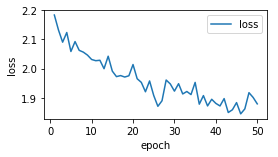

In [38]:
#--------------------------------------3.4 可视化损失值和准确率------------------------------------------------
# 可视化损失值
fig = plt.gcf()
fig.set_size_inches(4, 2)
plt.plot(epoch_list, loss_list, label='loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper right')

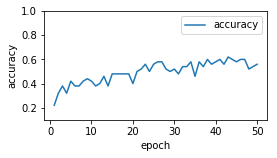

In [39]:
# 可视化准确率
plt.plot(epoch_list, accuracy_list, label='accuracy')
fig = plt.gcf()
fig.set_size_inches(4, 2)
plt.ylim(0.1, 1)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

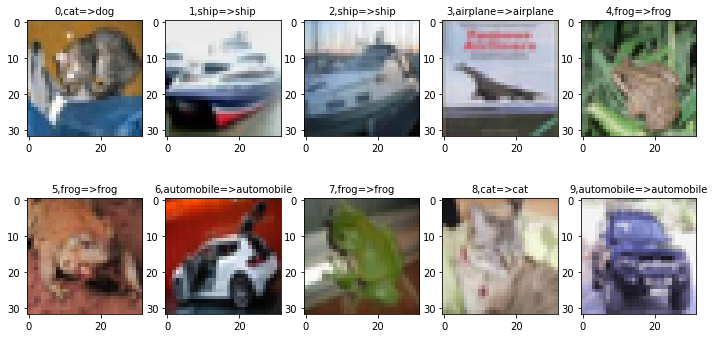

In [41]:
#--------------------------------------4.1 利用模型进行预测------------------------------------------------
test_pred = sess.run(pred, feed_dict={x: Xtest_normalize[:10]})
prediction_result = sess.run(tf.argmax(test_pred, 1))
# 可视化预测结果
plot_images_labels_prediction(Xtest, Ytest, prediction_result, 0, 10)